# Writing your own workflow - Equation of State

In this notebook, we will construct our own workflow to calculate the **Equation of State** (EOS). We will again start with
the necessary preparations, such as creating the structure, loading the code, defining the calculation paremeters, and
metadata options.

In [1]:
%load_ext aiida
%aiida

Loaded AiiDA DB environment - profile name: default.

In [2]:
from aiida import engine, orm
from aiida_quantumespresso.calculations.pw import PwCalculation
from ase.build import bulk

In [3]:
# Change the label here to 7.1 when running on nanoHUB
pw_code = orm.load_code('qe-7.2-pw@localhost')
si_structure = orm.StructureData(ase=bulk('Si', 'diamond', a=5.43)).store()

kpoints = orm.KpointsData()
kpoints.set_kpoints_mesh([2, 2, 2])

pseudo_family = orm.load_group('SSSP/1.3/PBEsol/efficiency')

cutoff_wfc, cutoff_rho = pseudo_family.get_recommended_cutoffs(
    structure=si_structure,
    unit='Ry'
)

parameters = {
    'CONTROL': {
        'calculation': 'scf',
    },
    'SYSTEM': {
        'occupations': 'smearing',
        'smearing': 'cold',
        'degauss': 0.02
    }
}

metadata_options = {
    "resources": {
        "num_machines": 1
    },
    "max_wallclock_seconds": 1800,
}

***
Now, let's consider the different steps that our workflow should compose:
1. Take an input structure and scale it to both compress and expand it
2. Calculate the SCF energies for all scaled structures
3. Plot the obtained results

Ideally, one would also relax the input structure for scaling, but for simplicity we will omit this step here.

Before going to the actual implementation, it is good to reiterate some of AiiDA's main concepts:

- **Provenance**: AiiDA tracks all data and processes in a provenance graph. To achieve this, data must be in the form
  of AiiDA data types, such as `Int`, `Float`, `StructureData`. This is because these classes inherit from the `Node`
  base class, which contains the functionality to store the data in the database and record the provenance.
- **Calcfunctions**: To run operations that create data, the corresponding Python functions must be converted into AiiDA
  `calcfunction`s, which can be achieved with the `@engine.calcfunction` decorator. It's important to note here, that,
  to keep provenance, these functions need to take AiiDA data `Node`s as inputs and return those as outputs.
- **WorkChains**: To define workflows in AiiDA one has to define a `WorkChain`, which contains the logic of the
  workflow. However, as opposed to `calcfunction`s, `WorkChain`s cannot create data. As such, all data creation has to
  be handled by `calcfunction`s instead, while the `WorkChain` can only *return* the existing data.

With this, let's generate the `calcfunction` to scale the structures:

In [8]:
@engine.calcfunction
def scale_structures(
    structure: orm.StructureData,  # AiiDA StructureData passed rather than ase.Atoms, which we will obtain internally
    factor_list: orm.List,  # AiiDA orm.List passed, the Python list will be obtained internally for the iteration
    ):

    scaled_structure_dict = {}

    for index, scaling_factor in enumerate(factor_list.get_list()):

        # Here we obtain the ase.Atoms object which we can modify
        # Note that the StructureData cannot be directly scaled, as it is immutable to keep provenance
        ase_structure = structure.get_ase()

        # Scale the ase.Atoms object
        new_cell = ase_structure.get_cell() * scaling_factor
        ase_structure.set_cell(new_cell, scale_atoms=True)

        scaled_structure_dict[f'structure_{index}'] = orm.StructureData(ase=ase_structure)

    return scaled_structure_dict

For simple Python base data types, such as `int` or `float`, the explicit conversion to AiiDA data types can also be
omitted, as converting them internally under the hood is possible.

Similarly, we need to define a `calcfunction` that returns the *volumes* and *energies* of the structures, and a
`calcfunction` that fits the EOS equation. The latter step could, in principle, also be done outside of the context of
the `WorkChain` with a normal Python function, however, this step would then **not** be recorded in the provenance of
the full workflow. The implementation of both `calcfunction`s is contained in the next cell, but is not that important,
so we will just skim over it:

In [52]:

@engine.calcfunction
def fit_eos(method: str = "birchmurnaghan", **scf_outputs) -> dict:
    """Fit the EOS of the data."""
    from ase.eos import EquationOfState
    from ase.units import kJ

    volumes_list = []
    energies = []
    for _, data in scf_outputs.items():
        energies.append(data.dict.energy)
        volumes_list.append(data.dict.volume)
    #
    eos = EquationOfState(volumes_list, energies, eos=method.value)
    v0, e0, B = eos.fit()
    # convert B to GPa
    B = B / kJ * 1.0e24
    eos = {"energy unit": "eV", "v0": v0, "e0": e0, "B": B}

    return {"eos_parameters": orm.Dict(eos),
            "energies": orm.List(list=energies),
            "volumes": orm.List(list=volumes_list)}

Finally, we define our `EquationOfStateWorkChain`. To this end, we inherit from `engine.WorkChain`. The main method of
our `WorkChain` is the `define` `classmethod`. In it, we define the `input`s, `output`s, and `outline` of our workflow:

```python
```

As you can see above, the outline of the workflow is quite simple: We first run the different SCF calculations, using
the previously defined `calcfunction` to scale our input structure, and then return the results. To run the SCF
calculations, we iterate over the scaled structures and prepare the `PwCalculation`s using the `ProcessBuilder`, as we
did before:

```python
```

In [57]:
class EquationOfStateWorkChain(engine.WorkChain):
    """WorkChain to compute Equation of State using Quantum ESPRESSO."""

    @classmethod
    def define(cls, spec):
        """Specify inputs and outputs."""
        super().define(spec)
        spec.input("code", valid_type=orm.Code)
        spec.input("structure", valid_type=orm.StructureData)
        spec.input("scale_factors", valid_type=orm.List)
        spec.input("eos_method", valid_type=orm.Str, default=orm.Str("birchmurnaghan"))

        spec.outline(
            cls.run_scfs,
            cls.fit_eos,
        )
        spec.output("eos_parameters", valid_type=orm.Dict)
        spec.output("energies", valid_type=orm.List)
        spec.output("volumes", valid_type=orm.List)

    def run_scfs(self):

        calcjob_dict = {}

        for label, rescaled_structure in scale_structures(self.inputs.structure, self.inputs.scale_factors).items():

            builder = PwCalculation.get_builder()
            builder.code = self.inputs.code
            builder.structure = rescaled_structure
            builder.parameters = orm.Dict(parameters)
            # pseudo_family = orm.load_group('SSSP/1.3/PBEsol/efficiency')
            builder.pseudos = pseudo_family.get_pseudos(structure=rescaled_structure)
            kpoints = orm.KpointsData()
            kpoints.set_kpoints_mesh([2, 2, 2])
            builder.kpoints = kpoints
            builder.metadata.options = metadata_options

            calcjob_dict[label] = self.submit(builder)

        self.ctx.labels = list(calcjob_dict.keys())

        return calcjob_dict

    def fit_eos(self):
        scf_outputs = {label: self.ctx[label].outputs.output_parameters for label in self.ctx.labels}
        result = fit_eos(self.inputs.eos_method, **scf_outputs)
        self.out('eos_parameters', result["eos_parameters"])
        self.out('energies', result["energies"])
        self.out('volumes', result["volumes"])

In [58]:
results = engine.run(
    EquationOfStateWorkChain,
    code=pw_code,
    structure=si_structure,
    scale_factors=orm.List([0.9, 0.95, 1.0, 1.05, 1.1]),
)

/home/xing/miniconda3/envs/aiida/lib/python3.11/site-packages/aiida/engine/processes/ports.py:156: UserWarning: default of input port `eos_method` is a `Node` instance, which can lead to unexpected side effects. It is advised to use a lambda instead, e.g.: `default=lambda: orm.Int(5)`.
  warnings.warn(UserWarning(message))


process_inited.node: uuid: c095b3f5-1d93-497d-ad37-4c736fc70259 (pk: 96205) (aiida.calculations:quantumespresso.pw)
process_inited.node: uuid: d79d967d-a7b9-40eb-8552-2d0ee0b7c4af (pk: 96208) (aiida.calculations:quantumespresso.pw)
process_inited.node: uuid: fd8c1a41-15c7-46a8-9d7c-9fabf8096066 (pk: 96211) (aiida.calculations:quantumespresso.pw)
process_inited.node: uuid: ad5d2ea1-103a-4815-9830-c6d62abe27ae (pk: 96214) (aiida.calculations:quantumespresso.pw)
process_inited.node: uuid: 1633d704-b054-4ae2-83bc-261272a88ddb (pk: 96217) (aiida.calculations:quantumespresso.pw)


## Get the results and plot them


Equation of state parameters:
B: 79.636137339453
v0: 43.448450305621
e0: -305.98667545249
v0: 43.448450305621


Text(0, 0.5, 'Energy (eV)')

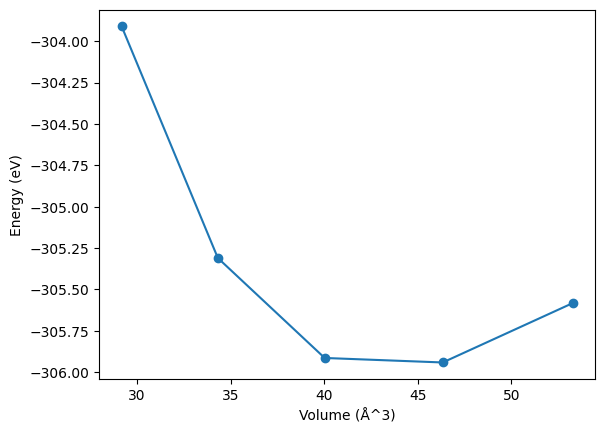

In [62]:
from matplotlib import pyplot as plt
print("Equation of state parameters:")
print('B: {B}\nv0: {v0}\ne0: {e0}\nv0: {v0}'.format(**results["eos_parameters"]))

plt.plot(
    results["volumes"].get_list(),
    results["energies"].get_list(),
    "-o",
)
plt.xlabel("Volume (Å^3)")
plt.ylabel("Energy (eV)")